In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 데이터 준비

In [3]:
data = pd.read_csv("data/005930.KS.csv", index_col='Date', parse_dates=True)
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284
...,...,...,...,...,...,...
2021-05-12,80800.0,81200.0,79800.0,80000.0,80000.000000,35812268
2021-05-13,78900.0,79600.0,78400.0,78500.0,78500.000000,31490096
2021-05-14,79000.0,80300.0,78900.0,80100.0,80100.000000,16450920


In [4]:
data = data['Close']
data.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

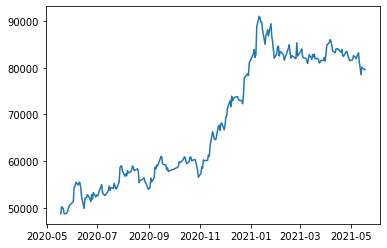

In [5]:
plt.plot(data)

# 전처리 수행

결측치 확인

In [6]:
data.isna().sum()

0

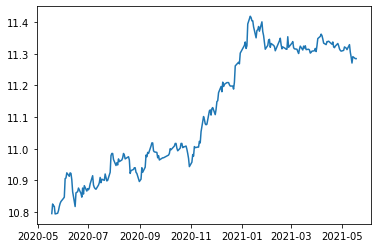

In [7]:
d_log = np.log(data)
plt.plot(d_log)

# 시계열 안정성 분석

In [8]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

In [9]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

## 정성적 그래프 분석

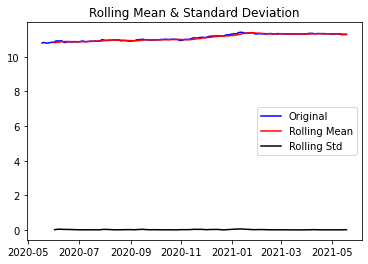

In [10]:
# 정성적 그래프 분석
plot_rolling_statistics(d_log, window=12)

## 정량적 Augmented Dicky-Fuller Test

In [11]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(d_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


## 시계열 분해 Time Series Decomposition

In [12]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(d_log, model='multiplicative', period = 30) 

# 추세(시간 추이에 따라 나타나는 평균값 변화 )
trend = decomposition.trend 

# 계절성(패턴이 파악되지 않은 주기적 변화)
seasonal = decomposition.seasonal 

# 원본(로그변환한) - 추세 - 계절성
residual = decomposition.resid 

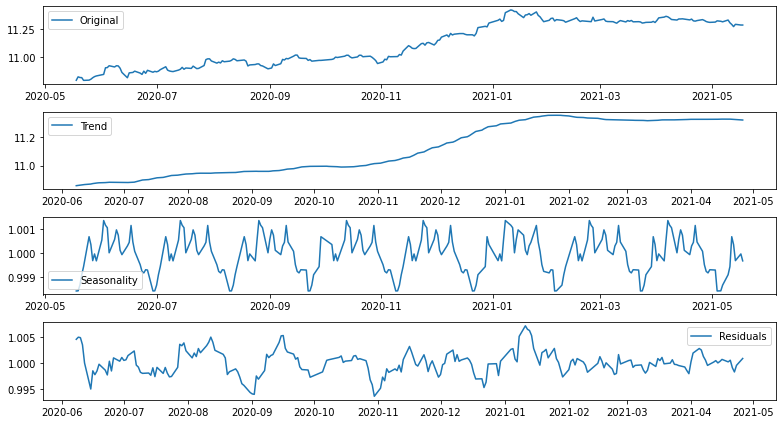

In [13]:
plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(d_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## Residual 확인

In [14]:
residual.isna().sum()

30

In [15]:
residual.dropna(inplace=True)
residual.isna().sum()

0

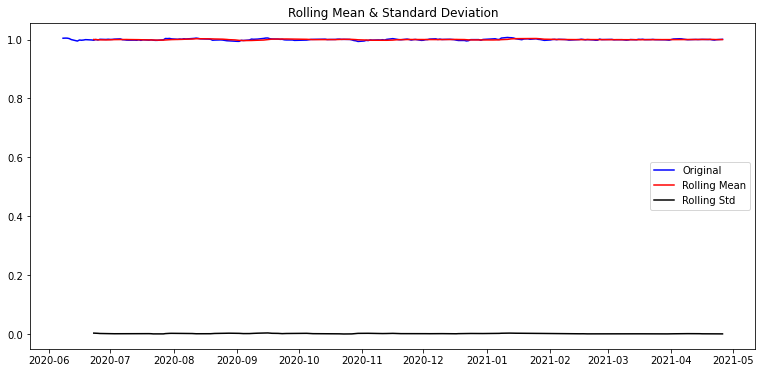

In [16]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

# 학습, 테스트 데이터 셋 생성

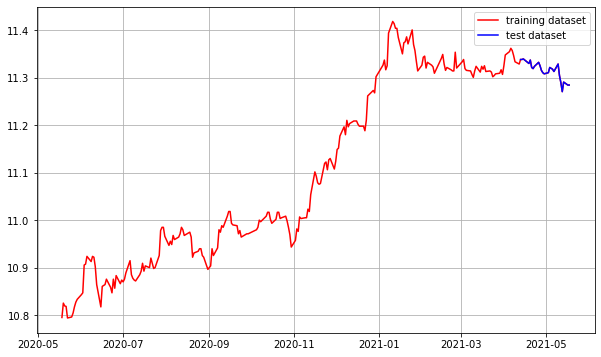

In [17]:
train_data, test_data = d_log[:int(len(d_log)*0.9)], d_log[int(len(d_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(d_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# ARIMA 모수찾기

### ACF, PACF 그려보기 -> p,q 구하기

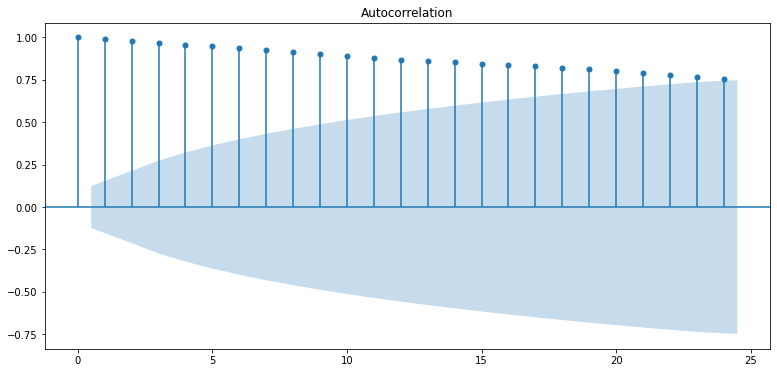

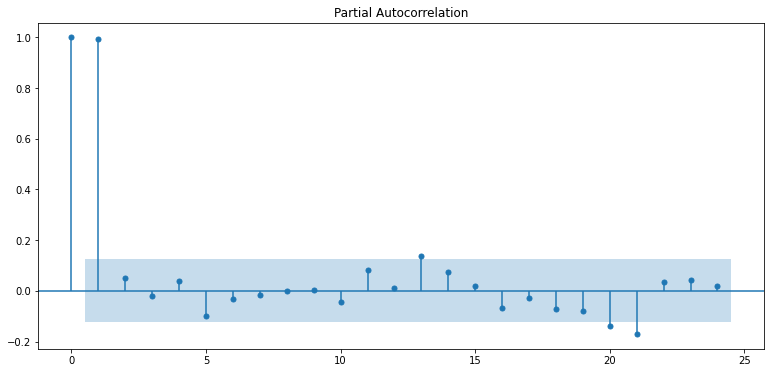

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(d_log)
plot_pacf(d_log)
plt.show()

PACF 그래프에서 p >= 2 에서 PACF가 0에 가깝기 때문에 p = 1  


### 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


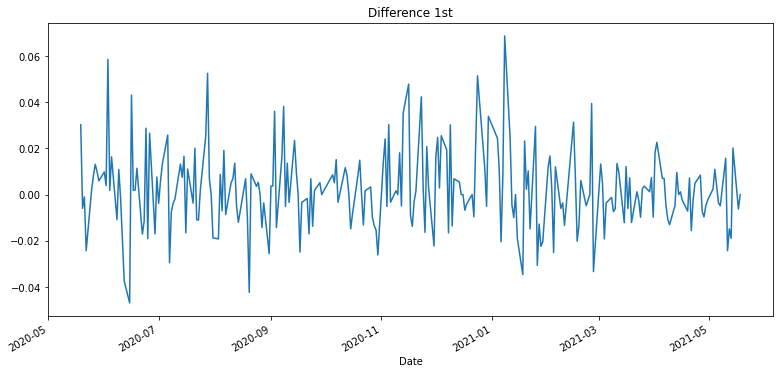

In [20]:
diff_1 = d_log.diff(periods = 1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# ARIMA 모델 훈련과 테스트

### ARIMA 모델 빌드 및 훈련

In [26]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp = -1)

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 11 Nov 2021   AIC                          -1164.792
Time:                        14:46:01   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

### 모델 테스트 및 플로팅

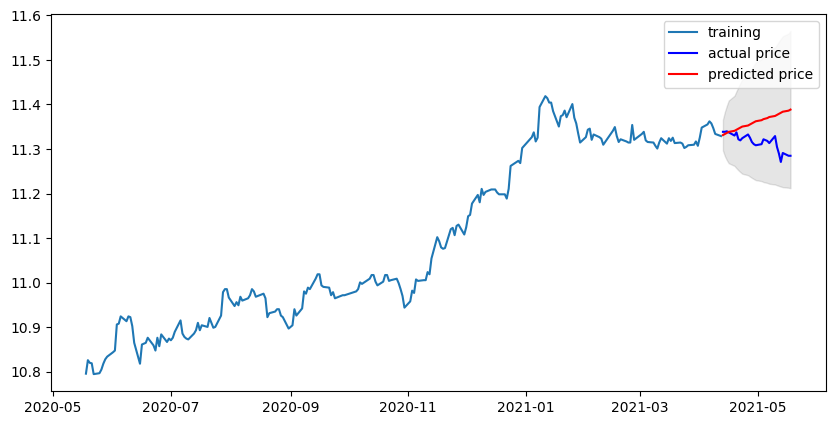

In [37]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

# -------------------------------- Question

In [39]:
fc_series.shape
print(fc)

[11.33126569 11.33364701 11.33603032 11.33841367 11.34079701 11.34318035
 11.3455637  11.34794704 11.35033038 11.35271373 11.35509707 11.35748041
 11.35986376 11.3622471  11.36463044 11.36701378 11.36939713 11.37178047
 11.37416381 11.37654716 11.3789305  11.38131384 11.38369719 11.38608053
 11.38846387]


In [36]:
model = ARIMA(train_data, order=(1, 1, 0))  # p값을 10으로 테스트
fitted_m = model.fit(dsip=-1)  
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

print(fc_series)
print(test_data.index)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

Date
2021-04-13    11.331509
2021-04-14    11.337452
2021-04-15    11.340581
2021-04-16    11.341390
2021-04-19    11.343364
2021-04-20    11.344346
2021-04-21    11.346323
2021-04-22    11.349034
2021-04-23    11.352841
2021-04-26    11.356113
2021-04-27    11.358672
2021-04-28    11.360666
2021-04-29    11.362757
2021-04-30    11.365228
2021-05-03    11.367557
2021-05-04    11.370111
2021-05-06    11.372605
2021-05-07    11.375075
2021-05-10    11.377351
2021-05-11    11.379635
2021-05-12    11.381976
2021-05-13    11.384385
2021-05-14    11.386820
2021-05-17    11.389203
2021-05-18    11.391615
dtype: float64
DatetimeIndex(['2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16',
               '2021-04-19', '2021-04-20', '2021-04-21', '2021-04-22',
               '2021-04-23', '2021-04-26', '2021-04-27', '2021-04-28',
               '2021-04-29', '2021-04-30', '2021-05-03', '2021-05-04',
               '2021-05-06', '2021-05-07', '2021-05-10', '2021-05-11',
               '2021-05-1

ValueError: Length of passed values is 3, index implies 25.

# ----------------------------

### 모델 최종 예측 모델 정확도 측정 (MAPE)

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%
